In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect



In [10]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Inspect Tables

In [16]:
# inspect measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# inspect station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


One table that has observations about precipitation and temperature for various dates.  The second table has a list of stations, lat, longitude, and elevation

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
latestDate = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
latestDate.date

'2017-08-23'

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()
    

In [35]:
# Save query results as a Pandas DataFrame and set the index
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

# set index gy date
precipitation_df.set_index('date', inplace = True)

#look at dataframe
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


<AxesSubplot:title={'center':'Precipitation: 8/23/16 - 8/23/17'}, xlabel='date'>

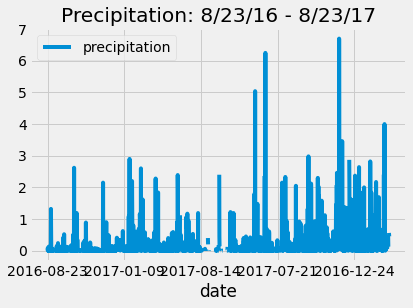

In [37]:
precipitation_df.plot(title="Precipitation: 8/23/16 - 8/23/17")

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station).count()
stations

9

In [52]:

# # Design a query to find the most active stations (i.e. what stations have the most rows?)
# # List the stations and the counts in descending order.
station_count = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_count:
    print(f"Station: {result[0]}\tCount: {result[1]}")

# Had to copy a peice of this part form Git hub to get it working correctlly


Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = 'USC00519281'
summary_of_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
print(f"Lowest Temp: {summary_of_temps[0][0]}")
print(f"Highest Temp: {summary_of_temps[0][1]}")
print(f"Average Temp: {round(summary_of_temps[0][2], 2)}")

Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66


In [64]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# save as dataframe
yearly_temp_df = pd.DataFrame(year_temp, columns = ['date', 'temperature'])
yearly_temp_df = yearly_temp_df.sort_index(ascending=True)
yearly_temp_df.head()


,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


<AxesSubplot:ylabel='Frequency'>

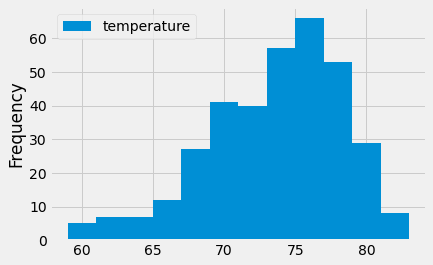

In [66]:
yearly_temp_df.plot(kind='hist', bins=12)

# Close session

In [67]:
# Close Session
session.close()